Spatio-Temporal Patterns of New York City
-----------------------------------------

In this script we will explore the spatial and temporal behavior of the people of New York as can be inferred by examining their cab usage. we will see how the patterns of cab usage change throughout the year, throughout the week and throughout the day, focusing on difference between weekdays and weekends.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

Load data, remove obvious outliers and convert everything to sensible units
--------------------------------------------------------------------



In [2]:
dataDir = 'data'
taxiDB = pd.read_csv(dataDir + 'train.csv')

# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.4), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

Plot the resulting histograms of trip duration, latitude and longitude 
-----------------------------------------------------------



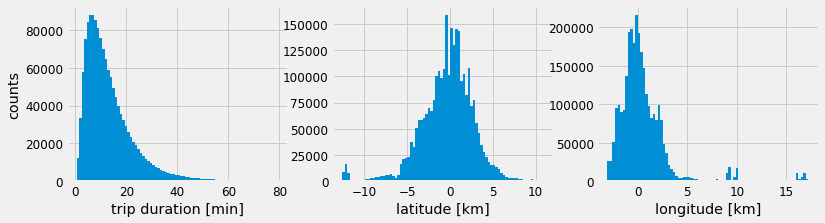

In [3]:
# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
axArray[0].hist(taxiDB['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')

Plot spatial density plot of the pickup and dropoff locations
-----------------------------------------------------



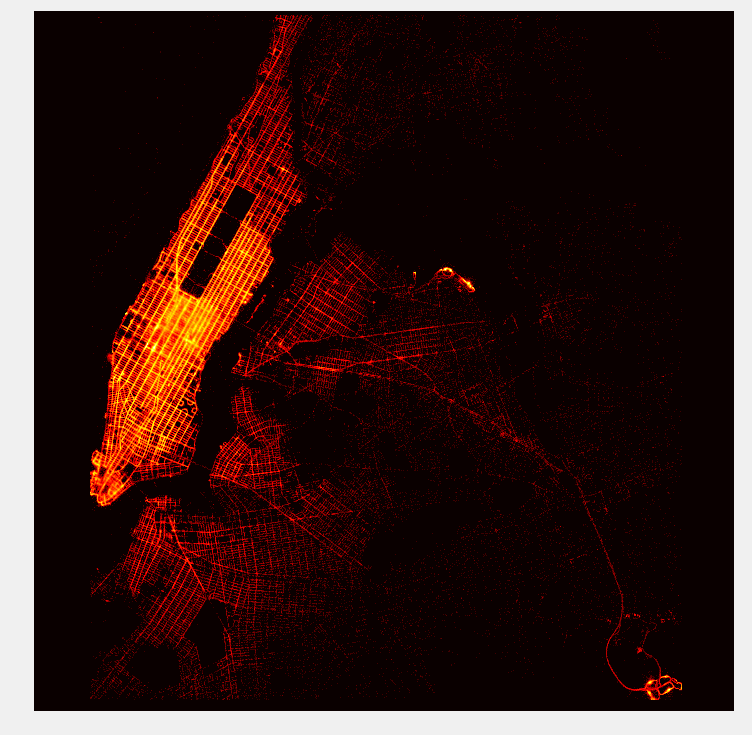

In [4]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

Zoom in on Manhattan
--------------------

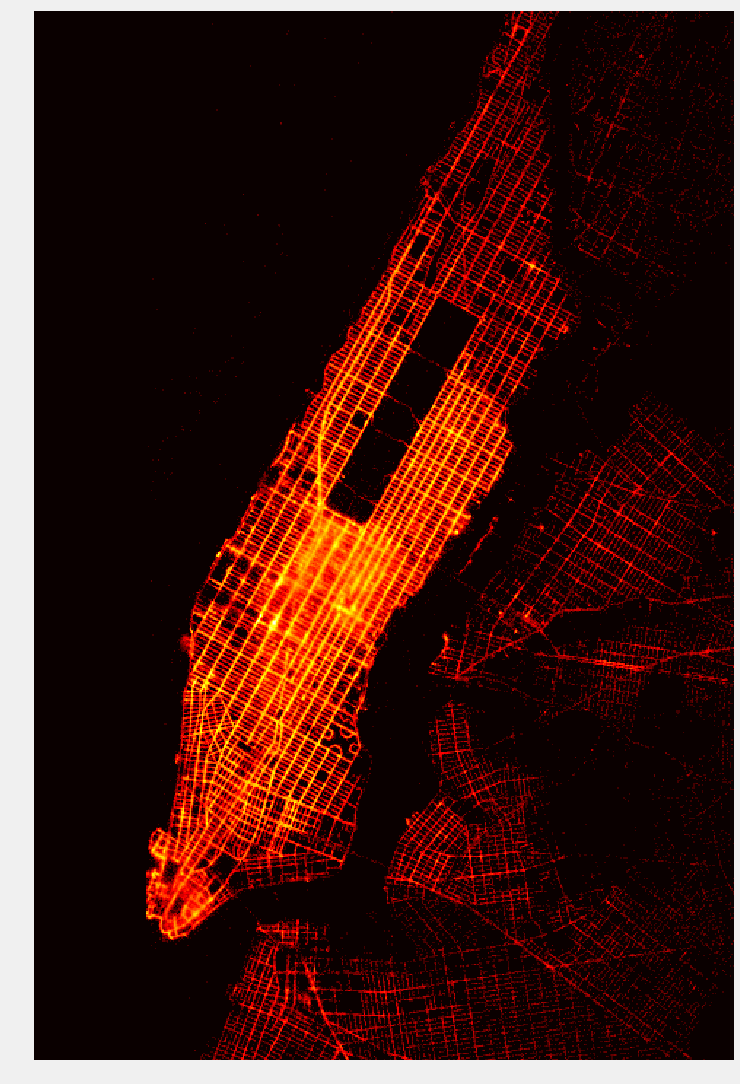

In [5]:
# zoom in on Manhattan 
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='hot')
ax.set_axis_off()

Create some useful fields for later
-------------------------



In [6]:
#%% create some new usefull fields

pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

Cluster The Trips and Look at their distribution
------------------------------------------------

every trip is essentially made up of 5 major attributes: pickup and dropoff locations and the trip duration.
let's cluster all 1.4 million trips to 80 stereotypical template trips and then look at the distribution of this "bag of trips" and how it changes over time

(0, 81)

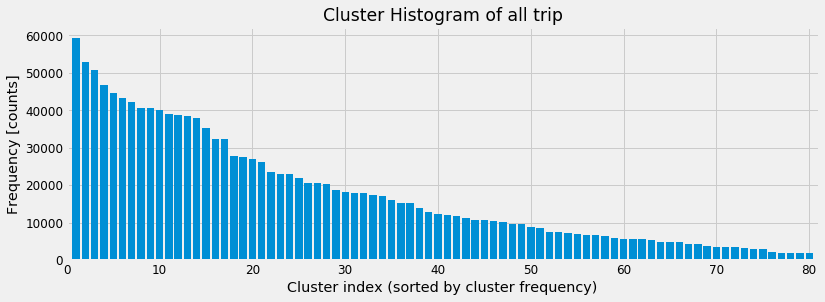

In [7]:
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=100000, n_init=100)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

Show the typical Trips on the Map
---------------------------------

The magenta circles are sources, the green circles are destinations and the arrows between them are drawn in cyan

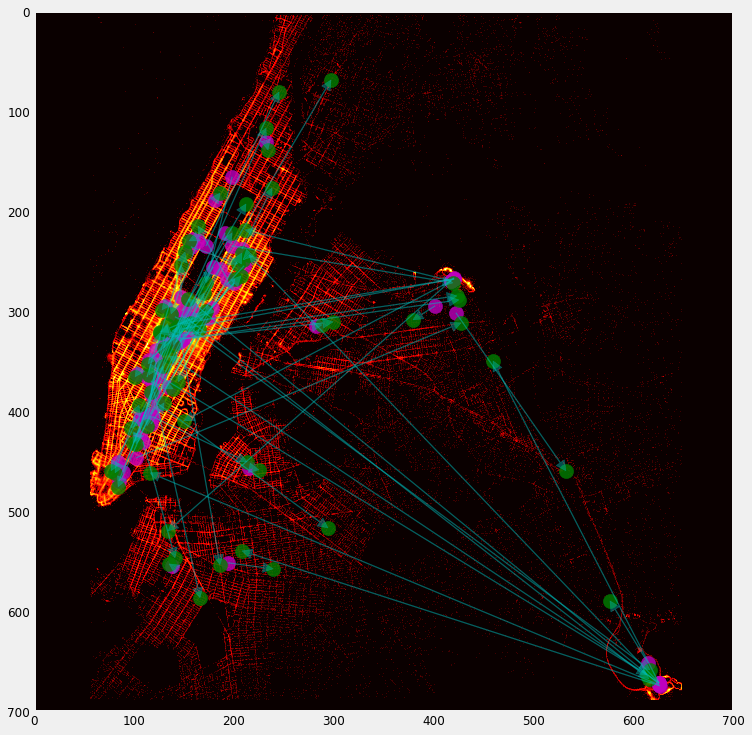

In [8]:
#%% show the templeate trips on the map
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length_includes_head=True)

The magenta circles are sources (pickup locations), the green circles are destinations (dropoff locations) and the arrows between them are drawn in cyan.
we can see an uneven distribution of sources and destinations with the periphery of Manhattan mostly serve as destination. (I'm sure some people might want to kill me for calling Brooklyn and Queens "the periphery"...)


----------
Let's now move on to examining the Temporal aspect of these trips:
-----------------------------------------------------------------


----------





WeekDay Trip Distribution for different hours of the day
--------------------------------------------------------
How does this "bag of trips" changes during the **regular work day**?


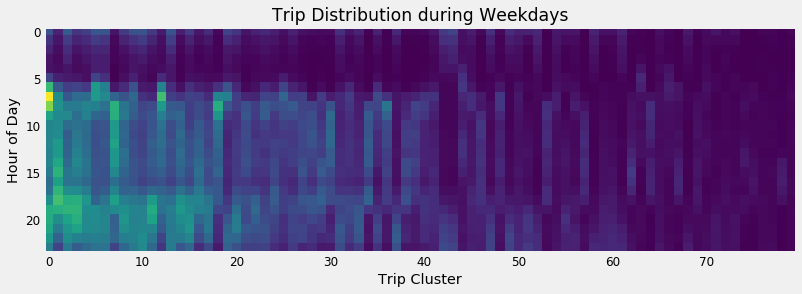

In [9]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,6)); plt.title('Trip Distribution during Weekdays')
plt.imshow(clusterDistributionHourOfDay_weekday); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Hour of Day')

Each row contains the "bag of trips" distribution where intensity represents trip frequency.

We can see that around 6AM people start waking up and (most likely) heading off to work. 
There is a second surge of taxi rides at around 18:00/19:00 (6PM/7PM) (most likely) getting back home.
 

WeekEnd Trip Distribution for different hours of the day
--------------------------------------------------------
How does this "bag of trips" changes during the **weekend**?


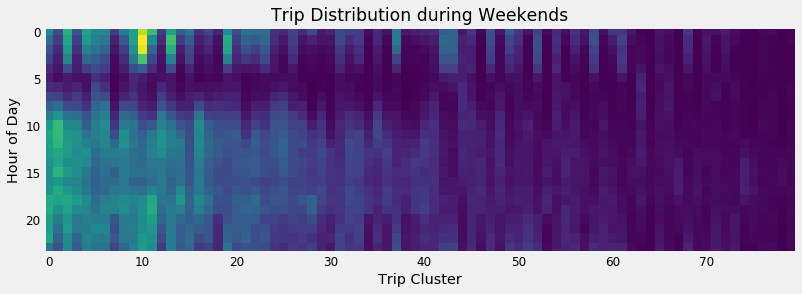

In [10]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,6)); plt.title('Trip Distribution during Weekends')
plt.imshow(clusterDistributionHourOfDay_weekend); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Hour of Day')

We can see that during weekends, people are much more active during the night, and we can also see that there are particular trips that are done during weekend nights and not others.

Weekly Trip Distribution for different days of the week
--------------------------------------------------------
How does this "bag of trips" changes during the **week**?


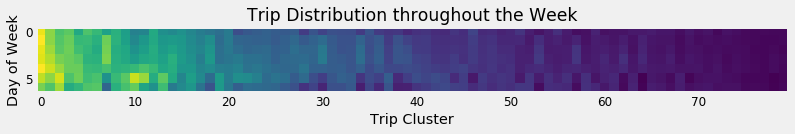

In [11]:
# calculate the trip distribution for day of week
daysOfWeek = np.sort(taxiDB['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = taxiDB['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')

We can see a reflection of what we saw from the two previous plots here. that during weekends, the pattern of trip distributions is somewhat different than that during the weekday.

Yearly Trip Distribution for different days of the year
--------------------------------------------------------
How does this "bag of trips" changes during the **year**?


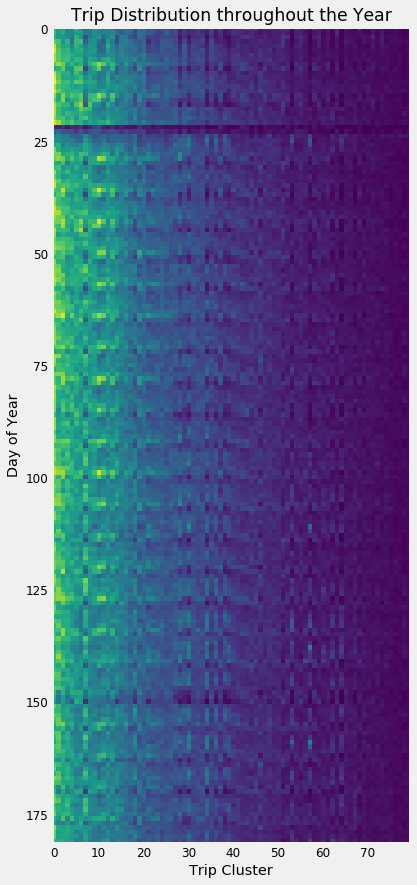

In [12]:
# calculate the trip distribution for day of year
daysOfYear = taxiDB['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear),numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = taxiDB['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(10,14)); plt.title('Trip Distribution throughout the Year')
plt.imshow(clusterDistributionDayOfYear); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Year')

We can see two large drops of activity in the data, one around day 20-25 (end of January), and the other around 145-150 (end of May). It would be interesting to lookup what exactly happened during those dates. But more interestingly, other than that, the most obvious pattern here is the periodicity. 

Let's now delve deeper into The Temporal aspect:
------------------------------------------------


Let's apply PCA to reduce the dimensionality from the 80 dimensional distribution vector to something more manageable such as 3 dimensions that we can plot and visualize more easily

In [13]:
#%% let's apply PCA to reduce the dimentionality from 80 dimentional distribution vector 
# to something more managble such as 3 dimentions

hoursOfYear = np.sort(taxiDB['hourOfYear'].astype(int).unique())
clusterDistributionHourOfYear = np.zeros((len(range(hoursOfYear[0],hoursOfYear[-1])),numClusters))
dayOfYearVec  = np.zeros(clusterDistributionHourOfYear.shape[0])
weekdayVec    = np.zeros(clusterDistributionHourOfYear.shape[0])
weekOfYearVec = np.zeros(clusterDistributionHourOfYear.shape[0])
for k, hour in enumerate(hoursOfYear):
    slectedInds = taxiDB['hourOfYear'].astype(int) == hour
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfYear[k,:] = currDistribution[sortedClusterInds]
    
    dayOfYearVec[k]  = taxiDB[slectedInds]['dayOfYear'].mean()
    weekdayVec[k]    = taxiDB[slectedInds]['dayOfWeek'].mean()
    weekOfYearVec[k] = taxiDB[slectedInds]['weekOfYear'].mean()

numComponents = 3
TripDistributionPCAModel = decomposition.PCA(n_components=numComponents,whiten=True)
compactClusterDistributionHourOfYear = TripDistributionPCAModel.fit_transform(clusterDistributionHourOfYear)

Weekly Periodicity
------------------

Here we'll show the temporal evolution of the 3 main principal components coefficients during the week

(0, 167)

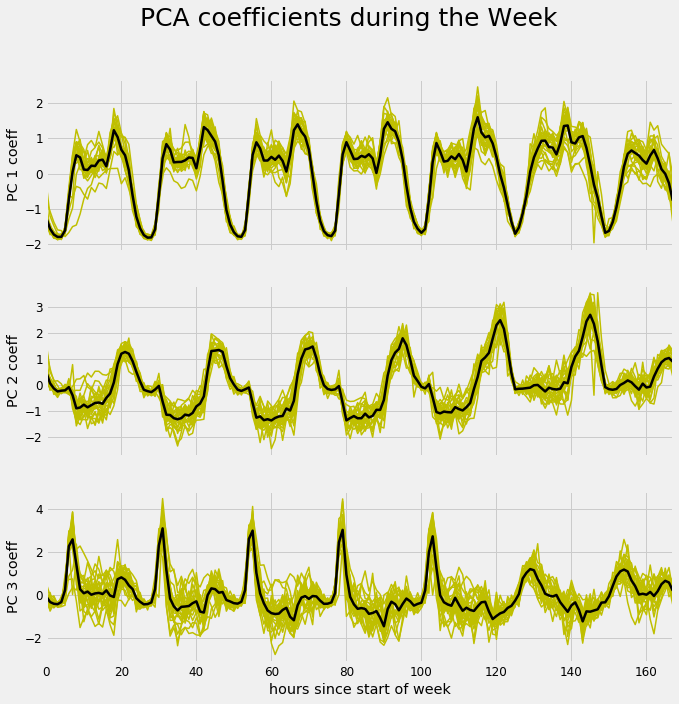

In [14]:
# collect traces for all weeks of year
listOfFullWeeks = []
for uniqueVal in np.unique(weekOfYearVec):
    if (weekOfYearVec == uniqueVal).sum() == 24*7:
        listOfFullWeeks.append(uniqueVal)

weeklyTraces = np.zeros((24*7,numComponents,len(listOfFullWeeks)))
for k, weekInd in enumerate(listOfFullWeeks):
    weeklyTraces[:,:,k] = compactClusterDistributionHourOfYear[weekOfYearVec == weekInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(10,10))
fig.suptitle('PCA coefficients during the Week', fontsize=25)
for PC_coeff in range(numComponents):
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:],'y',linewidth=1.5)
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    axArray[PC_coeff].set_ylabel('PC %d coeff' %(PC_coeff+1))
    
axArray[PC_coeff].set_xlabel('hours since start of week')
axArray[PC_coeff].set_xlim(0,24*7-1)

In yellow is the data from all full weeks overlain on top of each other. In black are the average traces.

We can clearly see the periodicity here as well as the **difference between the regular weekdays and the weekends**.

Daily Periodicity
------------------

Here we'll show the temporal evolution of the 3 main principal components coefficients during the day

(-3.5, 3.5)

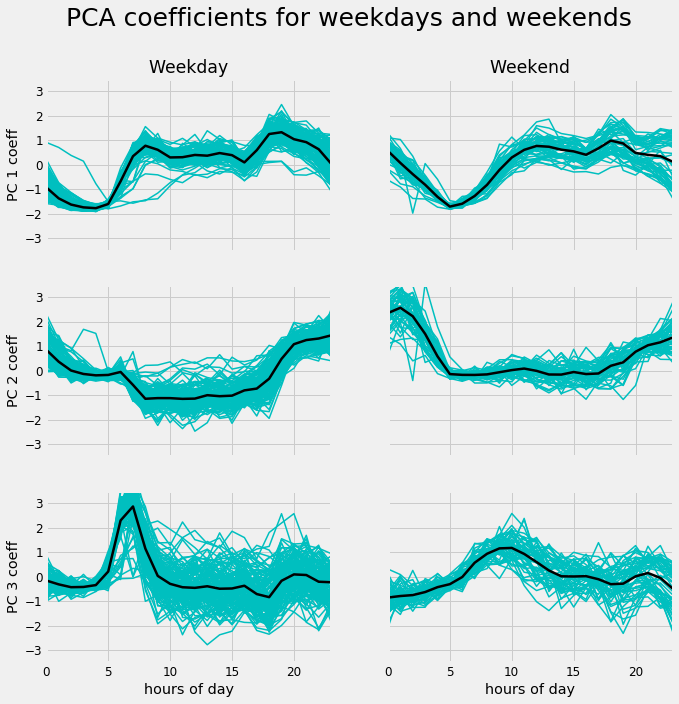

In [15]:
# collect traces for weekdays and weekends 
listOfFullWeekdays = []
listOfFullWeekends = []
for uniqueVal in np.unique(dayOfYearVec):
    if (dayOfYearVec == uniqueVal).sum() == 24:
        if weekdayVec[dayOfYearVec == uniqueVal][0] <= 4:
            listOfFullWeekdays.append(uniqueVal)
        else:
            listOfFullWeekends.append(uniqueVal)

weekdayTraces = np.zeros((24,numComponents,len(listOfFullWeekdays)))
for k, dayInd in enumerate(listOfFullWeekdays):
    weekdayTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

weekendTraces = np.zeros((24,numComponents,len(listOfFullWeekends)))
for k, dayInd in enumerate(listOfFullWeekends):
    weekendTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=2,sharex=True,sharey=True, figsize=(10,10))
fig.suptitle('PCA coefficients for weekdays and weekends', fontsize=25)
for PC_coeff in range(numComponents):
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    axArray[PC_coeff][0].set_ylabel('PC %d coeff' %(PC_coeff+1))
    
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    
    if PC_coeff == 0:
        axArray[PC_coeff][0].set_title('Weekday')
        axArray[PC_coeff][1].set_title('Weekend')
    
axArray[PC_coeff][0].set_xlabel('hours of day')
axArray[PC_coeff][1].set_xlabel('hours of day')
axArray[PC_coeff][0].set_xlim(0,23)
axArray[PC_coeff][0].set_ylim(-3.5,3.5)

Recall that we can go back and see exactly **what each PC coefficient means** by looking at the eigenvectors (i.e. trip distributions). Let's do that:


(0, 80.5)

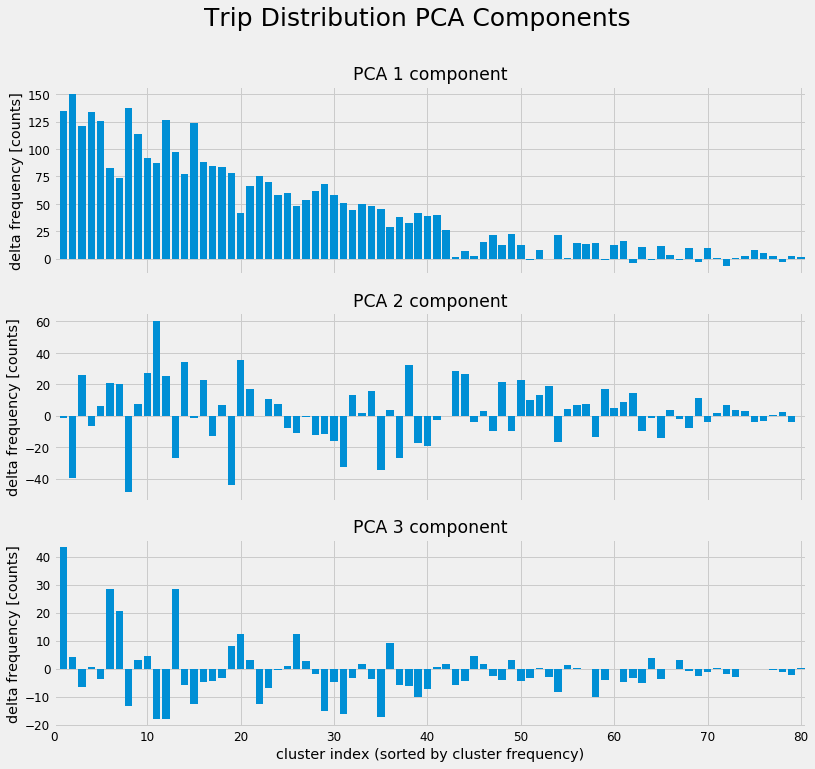

In [16]:
#%% examine what different PC coefficients mean by looking at their trip template distributions
fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)
for PC_coeff in range(numComponents):
    tripTemplateDistributionDifference = TripDistributionPCAModel.components_[PC_coeff,:] * \
                                         TripDistributionPCAModel.explained_variance_[PC_coeff]
    axArray[PC_coeff].bar(range(1,numClusters+1),tripTemplateDistributionDifference)
    axArray[PC_coeff].set_title('PCA %d component' %(PC_coeff+1))
    axArray[PC_coeff].set_ylabel('delta frequency [counts]')
    
axArray[PC_coeff].set_xlabel('cluster index (sorted by cluster frequency)')
axArray[PC_coeff].set_xlim(0,numClusters+0.5)

We can see that the **first PCA component** looks very similar to the overall trip distribution, suggesting that it's mainly a "gain" component that controls just the **number of total trips** in that period of time. 

The second and third components have different patterns going up and down in them. 

**Let's examine what those patterns are:**


PC 2 large deviating trips
--------------------------
Arrows in red will show trips that are increasing when PC 2 coefficient increases.

Arrows in blue will show trips that are decreasing when PC 2 coefficient increases.

Magenta circles are the sources, and Green circles are the destinations.


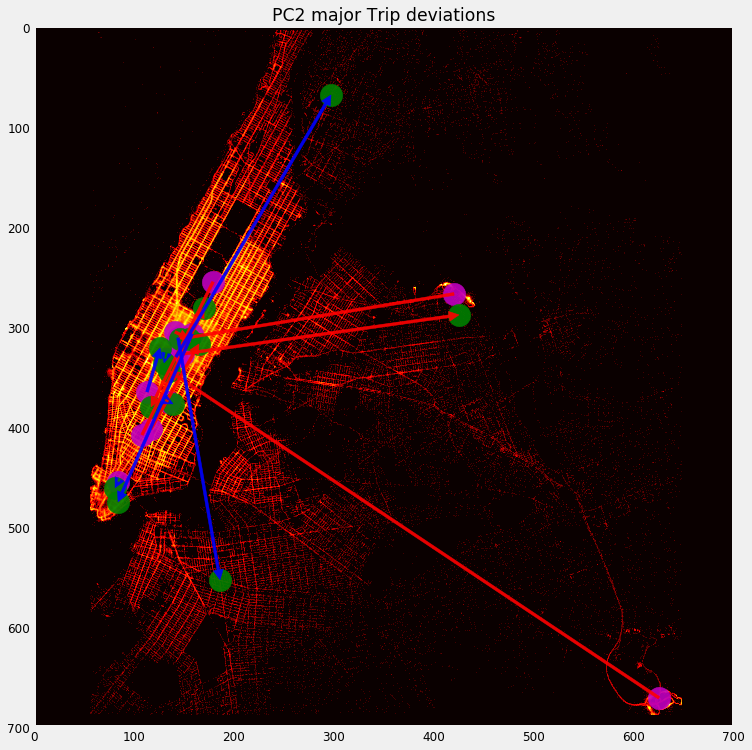

In [17]:
#%% put the large deviating trips of each component back on the map
numTopAndBottomTripToShow = 7

# meaning of 2nd PC
sortedTripClusters_PC2 = np.argsort(TripDistributionPCAModel.components_[1,:])
topPositiveTripClusterInds = sortedTripClusters_PC2[-numTopAndBottomTripToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC2[:numTopAndBottomTripToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC2 major Trip deviations')

**Arrows** in **red** show trips that are increasing when PC coefficient increases.

**Arrows** in **blue** show trips that are decreasing when PC coefficient increases.

**Magenta circles** are the sources, and **Green circles** are the destinations.


PC 3 large deviating trips
--------------------------


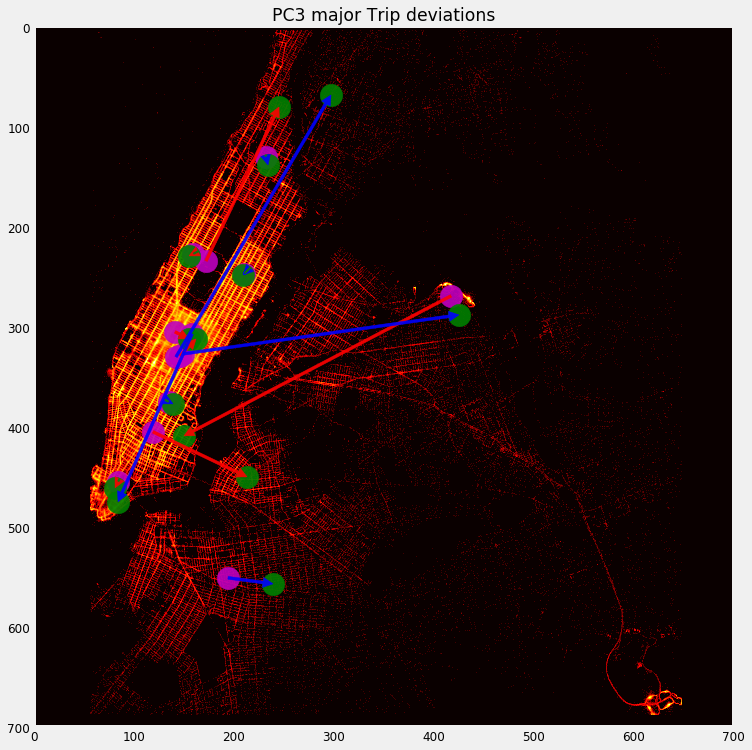

In [18]:
# meaning of 3rd PC
sortedTripClusters_PC3 = np.argsort(TripDistributionPCAModel.components_[2,:])
topPositiveTripClusterInds = sortedTripClusters_PC3[-numTopAndBottomTripToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC3[:numTopAndBottomTripToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC3 major Trip deviations')